## Check GPU

In [4]:
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

!nvidia-smi


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Wed Dec 25 14:42:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             12W /   70W |       3MiB /  15360MiB |      0%      D

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Import library

In [5]:
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Embedding, BatchNormalization, Dropout, Conv1D
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import os
import re
import matplotlib.pyplot as plt
import string
import nltk
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Get data

In [15]:
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding = "latin", header = None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [16]:
df.columns = ["sentiment", "id", "data", "query", "user_id", "text"]
df.head()

,sentiment,id,data,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [17]:
df = df.drop(["id", "data", "query", "user_id"], axis = 1)
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [18]:
df.sentiment = df.sentiment.map({0:"Negative", 4:"Positive"})
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


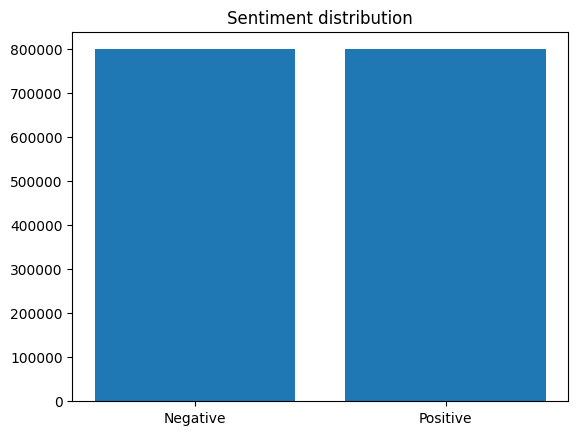

In [20]:
count = df.sentiment.value_counts()
plt.bar(count.index, counts)
plt.title("Sentiment distribution")
plt.show()

## Preprocessing

In [21]:
df.sentiment = df.sentiment.map({
    "Positive":1,
    "Negative":0
})
df

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


In [24]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
def preprocessing_text(text):
    #lower text
    text = str(text).lower()
    #remove HTML tag
    text = re.sub("<.*?>","", text)
    #remove URL
    text = re.sub("https?://\S+|www\.\S+","", text)
    #remove punctuation
    text = re.sub(f"[{string.punctuation}]","",text)
    #lemmatization
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in word_tokenize(text)]
    return " ".join(text)

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()



  inflating: /usr/share/nltk_data/corpora/wordnet/data.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.noun  
  inflating: /usr/share/nltk_data/corpora/wordnet/adj.exc  


In [25]:
df.text = df.text.apply(preprocessing_text)

In [26]:
X = df.text.to_list()
y = df.sentiment.to_list()

In [27]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)


## Machine Learning Base Model: TF-IDF vectorization and LogisticRegression

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [29]:
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("lr", LogisticRegression())
])

model_0.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('lr', LogisticRegression())])

In [30]:
#create function to evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def calculate_result(y_true, y_pred):
    model_accuracy = accuracy_score(y_true, y_pred)
    model_precision = precision_score(y_true, y_pred)
    model_recall = recall_score(y_true, y_pred)
    model_f1 = f1_score(y_true, y_pred)
    result = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1
    }
    return result

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [62]:
model_0_pred = model_0.predict(X_test)
calculate_result(y_test, model_0_pred)

{'accuracy': 0.80080625,
 'precision': 0.7963594436130805,
 'recall': 0.8095968476051526,
 'f1': 0.8029235896833398}

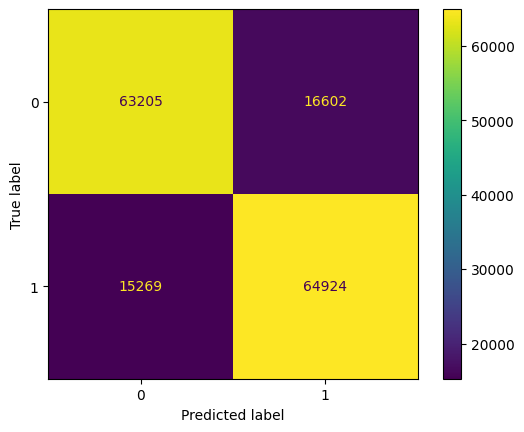

In [64]:
plot_confusion_matrix(y_test, model_0_pred)

## Deep Learning Model: Embedding and LSTM

In [37]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [38]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [39]:
sentence_length = [len(sentence.split()) for sentence in X_train]
np.percentile(sentence_length, 95)

25.0

In [40]:
text_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
    output_sequence_length=24
)
text_vectorizer.adapt(X_train)

In [41]:
vocab_size = len(text_vectorizer.get_vocabulary())
vocab_size

660823

In [42]:
model_1 = tf.keras.Sequential([
    tf.keras.Input(shape = (1,), dtype = tf.string),
    text_vectorizer,
    Embedding(
        input_dim = vocab_size,
        output_dim = 128
    ),
    Conv1D(64, 5, activation = "relu"),
    Bidirectional(LSTM(
        64, return_sequences = True, recurrent_dropout = 0.2
    )),
    GRU(32),
    Dense(32, activation = "relu"),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation = "sigmoid")
])

model_1.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [43]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 24)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 24, 128)             │      84,585,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 20, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 20, 128)             │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 32)                  │          15,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,709,185 (323.14 MB)

 Trainable params: 84,709,121 (323.14 MB)

 Non-trainable params: 64 (256.00 B)

In [44]:
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.1,
    min_lr = 0.00001,
    monitor = 'val_loss',
    verbose = 1,
    min_delta=0.01)

Because the data is too large, I will just use 20% dataset

In [47]:
history_1 = model_1.fit(
    train_dataset,
    steps_per_epoch = int(0.2 * len(train_dataset)),
    epochs = 5,
    validation_data = val_dataset,
    validation_steps = int(0.2 * len(val_dataset)),
    callbacks=[ReduceLROnPlateau]
)

Epoch 1/5
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 697s 87ms/step - accuracy: 0.7639 - loss: 0.5016 - val_accuracy: 0.8052 - val_loss: 0.4276 - learning_rate: 0.0010
Epoch 2/5
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 693s 87ms/step - accuracy: 0.8017 - loss: 0.4406 - val_accuracy: 0.8141 - val_loss: 0.4081 - learning_rate: 0.0010
Epoch 3/5
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 687s 86ms/step - accuracy: 0.8098 - loss: 0.4267 - val_accuracy: 0.8170 - val_loss: 0.4005 - learning_rate: 0.0010
Epoch 4/5
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 684s 86ms/step - accuracy: 0.8131 - loss: 0.4203 - val_accuracy: 0.8243 - val_loss: 0.3849 - learning_rate: 0.0010
Epoch 5/5
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 689s 86ms/step - accuracy: 0.8182 - loss: 0.4127 - val_accuracy: 0.8205 - val_loss: 0.3940 - learning_rate: 0.0010


In [48]:
def plot_curve(history):
    plt.figure(figsize = (15,5))
    result = pd.DataFrame(history.history)
    plt.subplot(1,2,1)
    plt.plot(result.loss, label = "loss")
    plt.plot(result.val_loss, label = "val_loss")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(result.accuracy, label = "accuracy")
    plt.plot(result.val_accuracy, label = "val_accuracy")
    plt.legend()

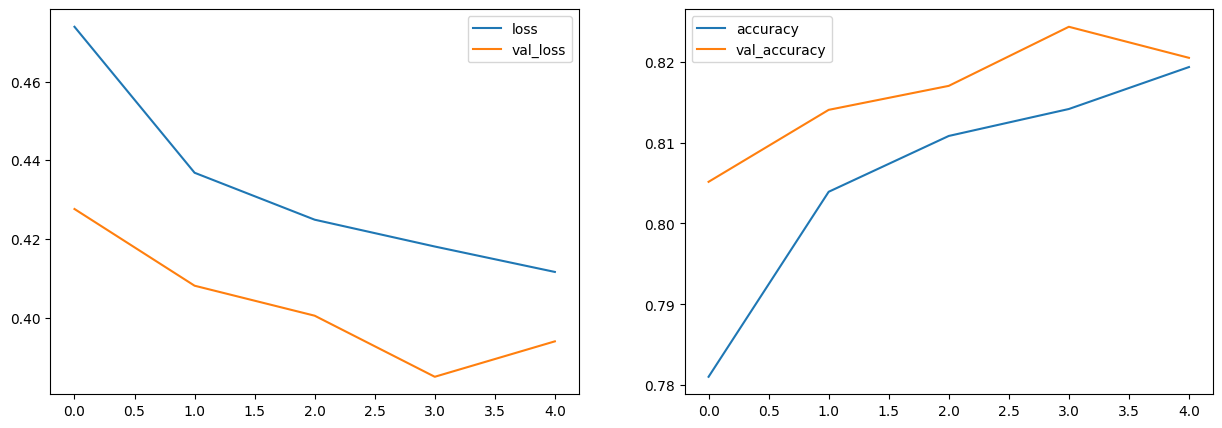

In [51]:
plot_curve(history_1)

In [57]:
model_1_pred = model_1.predict(test_dataset, steps = int(0.2 * len(test_dataset)))
model_1_pred

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step


array([[0.5266725 ],
       [0.99435437],
       [0.99467117],
       ...,
       [0.4679408 ],
       [0.4037209 ],
       [0.8260836 ]], dtype=float32)

In [66]:
calculate_result(y_test[:32000], tf.round(model_1_pred))

{'accuracy': 0.8274375,
 'precision': 0.8382022471910112,
 'recall': 0.8130410412904029,
 'f1': 0.8254299443601416}

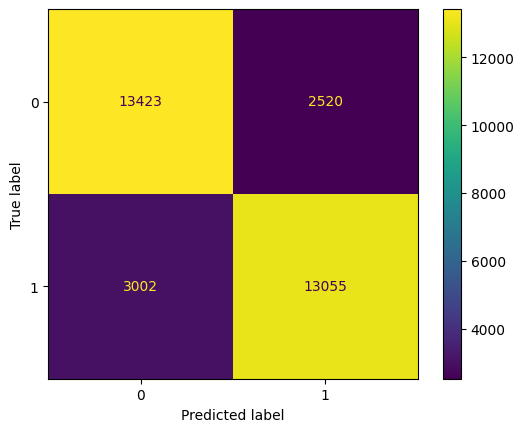

In [67]:
plot_confusion_matrix(y_test[:32000], tf.round(model_1_pred))

Accuracy is 82%, which is good enough
